In [7]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#Read in data
RawDrainageData=pd.read_csv('K:\Rainshelter\StonySoilLysimeters\DownloadedData\StonyLysimetersDrain.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         #index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

In [9]:
#Read in data
RawDrainageData=pd.read_csv('K:\Rainshelter\StonySoilLysimeters\DownloadedData\StonyLysimetersDrain.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')
#Drop empty columns
RawDrainageData.drop(['RECORD','BattV_Avg','PTemp_C_Avg','AirTC_Avg','RH_Max','SlrkW_Avg','SlrMJ_Tot','Rain_mm_Tot','WS_ms_Avg'],axis=1,inplace=True)

#Bring in all index data
DrainageDataIndex=pd.read_csv('D:\GitHubRepos\StonySoilLysimeters\IndexFiles\DrainageIndex.csv',
                         index_col = 0)
DrainageDataIndex = DrainageDataIndex.ix[4:28]
#Apply indexes to data
DrainageDataTransposed = RawDrainageData.transpose()
DrainageDataIndexed = pd.concat([DrainageDataIndex,DrainageDataTransposed], axis=1)
DrainageDataIndexed.index.name='ColumnHeader',
DrainageDataIndexed.set_index(['Measurement','Gravels','Stones','Column','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
                        append=False, inplace=True)
DrainageDataIndexed.sort(inplace=True)
DrainageData=DrainageDataIndexed.transpose()
DrainageData.index = DrainageData.index.to_datetime()  ## for some reason the concat function changes the data type on the date indes so need to change it back

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:21: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [10]:
ManualIndex = DrainageDataIndex.ix[:,1:6]
ManualIndex.set_index('Treatment', inplace=True)

In [11]:
ManualData = pd.read_excel('K:\Rainshelter\StonySoilLysimeters\Packing lysimeter drainage.xlsx',sheetname = 'DrainageCondensed',index_col=0)
ManualData.columns.name='Treatment'
MD = pd.concat([ManualIndex,ManualData.transpose()],axis=1)
MD.set_index(['Gravels','Stones','Column','Block'],inplace=True)
ManualData = MD.transpose()
ManualData.sort_index(axis=1,inplace=True)

##Calibrate spoon tips against measured drainage volumes

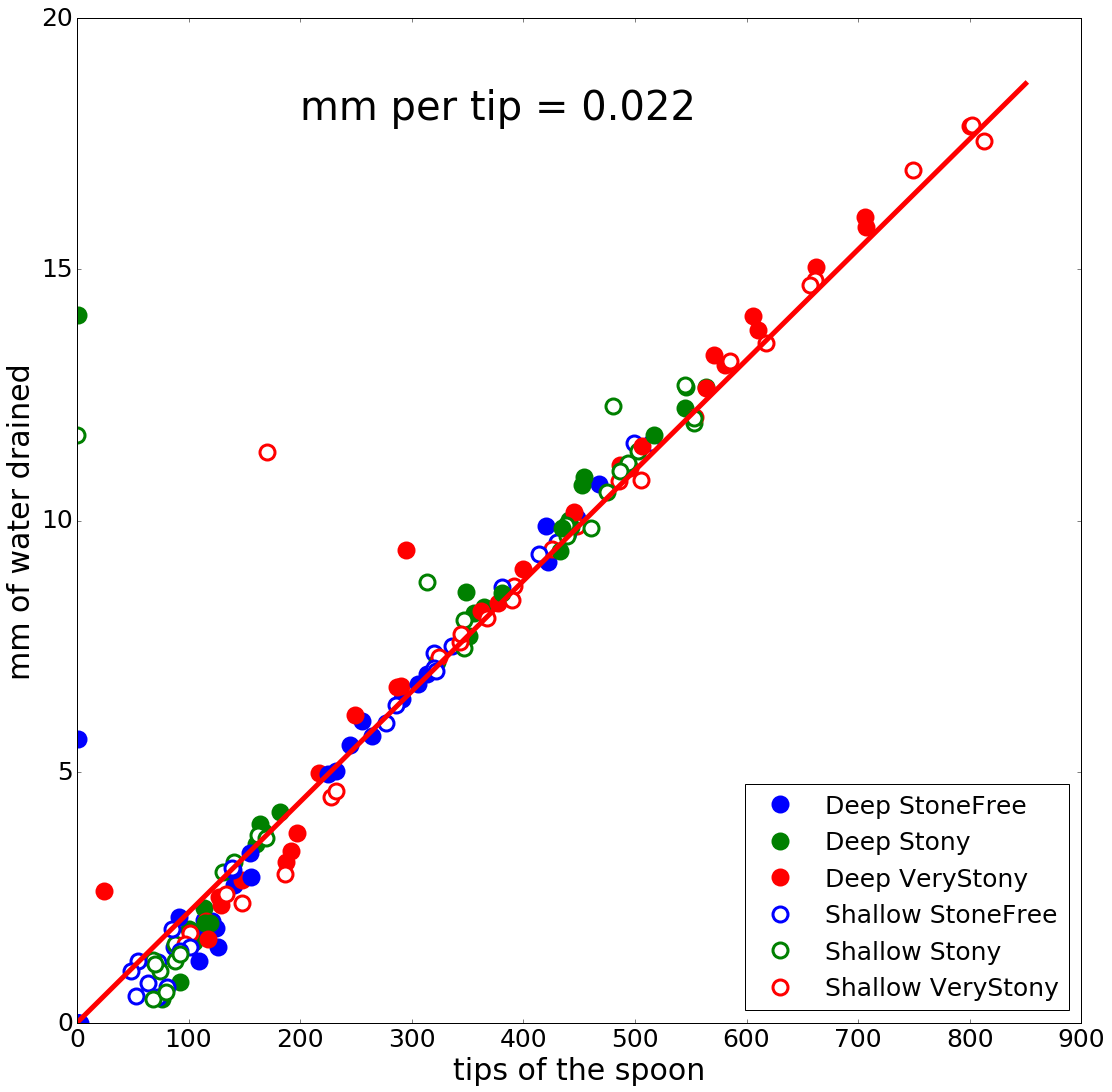

In [12]:
#area of the lysimeter
lysoArea = np.pi * np.power(0.25,2)

first = 15
last = 22
Observations = last - first
Observations = int(Observations)

fig = plt.figure(figsize=(18,18))

for obs in range(first,last):
    StartDate = ManualData.ix[obs,:].name
    EndDate = ManualData.ix[obs+1,:].name
    
    Gravels = ['Deep','Shallow']
    Stones = ['StoneFree','Stony','VeryStony']
    fills = ['b','g','r','w','w','w']
    colors = ['b','g','r']

    TreatPos = 0
    for Grav in Gravels:
        StonPos = 0
        for Ston in Stones:
            Tips = DrainageData.ix[StartDate:EndDate,('Drainage',Grav,Ston)].sum(axis=0)
            #divide drainage by 1000 to convert to liters and divide by lysimeter area to convert to mm/m2
            #which is the same as mm drainage
            Drain = ManualData.ix[EndDate,(Grav,Ston)]/1000/lysoArea
            plt.plot(Tips,Drain,'o',markersize=15,mec = colors[StonPos],mfc = fills[TreatPos],mew=3, label = Grav+' ' +Ston)
            StonPos+=1
            TreatPos+=1
    if obs == 15:
        plt.legend(loc=4,numpoints=1,fontsize = 25)

mm_per_tip = .022
plt.plot([0,850],[0,850*mm_per_tip],'-',linewidth = 5,color='r')
plt.text(200,18,'mm per tip = '+str(mm_per_tip),fontsize=40)
plt.ylabel('mm of water drained', fontsize=30)
plt.xlabel('tips of the spoon', fontsize=30)
plt.tick_params(labelsize=25)


##Apply conversion

In [13]:
Drainage = DrainageData.multiply(mm_per_tip)

##Clean up data where spoons were not working

In [14]:
mean = Drainage.ix[:'2015-07-13',('Drainage','Deep','Stony')].ix[:,0:3].mean(axis=1)
Drainage.ix[:'2015-07-13',('Drainage','Deep','Stony','8')] = mean 
mean = Drainage.ix[:'2015-07-13',('Drainage','Shallow','Stony')].ix[:,1:4].mean(axis=1)
Drainage.ix[:'2015-07-13',('Drainage','Shallow','Stony','12')] = mean 


In [15]:
Drainage.to_pickle('.\DataFrames\LysoDrainage_df')

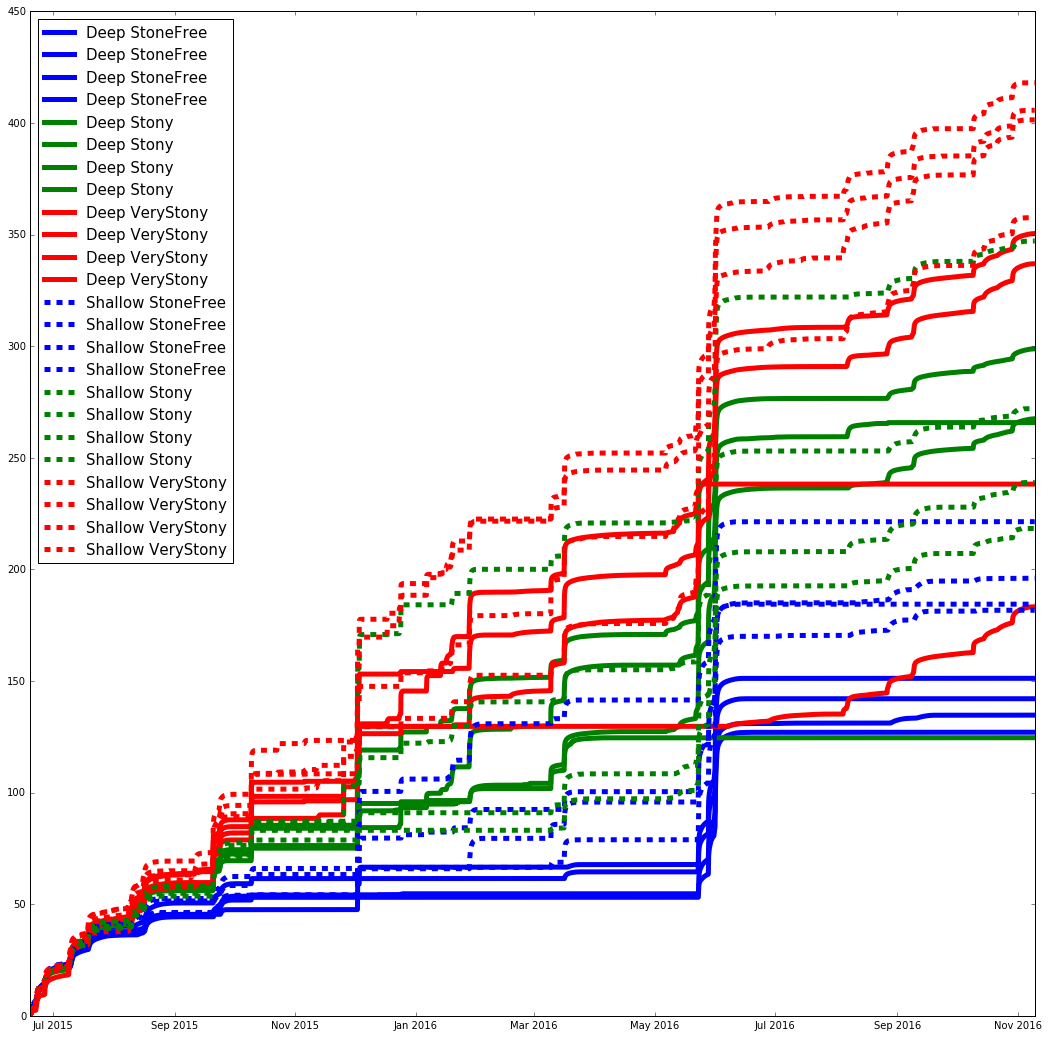

In [16]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

fig = plt.figure(figsize=(18,18))

GravPos = 0
for Grav in Gravels:
    StonPos = 0
    for Ston in Stones:
        plt.plot(Drainage.ix[:,('Drainage',Grav,Ston)].index,
                 Drainage.ix[:,('Drainage',Grav,Ston)].cumsum(),
                 lines[GravPos],
                color = colors[StonPos],
                linewidth = 5,
                label = Grav+' ' +Ston)
        StonPos += 1
    GravPos +=1
plt.legend(loc=2,numpoints=1,fontsize = 15)

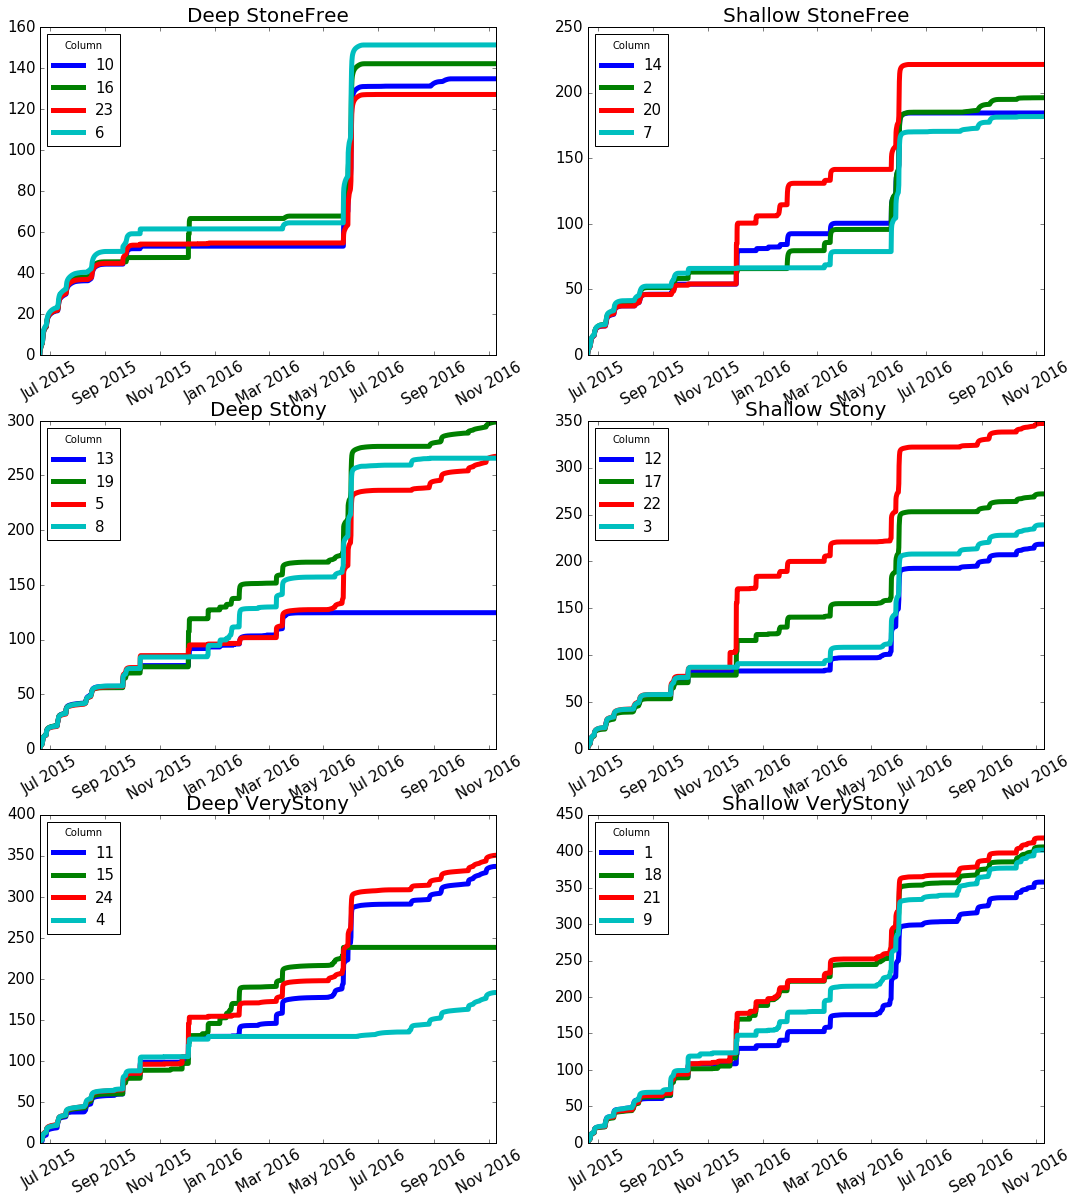

In [17]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,20))

TreatPos = 1
for Ston in Stones:
    for Grav in Gravels:
        for rep in [0,1,2,3]:
            fig = Graph.add_subplot(3,2,TreatPos)
            Labels = Drainage.ix[:,('Drainage',Grav,Ston)].ix[:,rep].name[0]
            plt.plot(Drainage.ix[:,('Drainage',Grav,Ston)].ix[:,rep].index,
                     Drainage.ix[:,('Drainage',Grav,Ston)].ix[:,rep].cumsum(),
                    linewidth = 5, label = Labels)
            plt.title(Grav+' ' +Ston, fontsize=20)
            plt.xticks(rotation=30)
            plt.tick_params(labelsize=15)
        TreatPos += 1
        plt.legend(loc=2,numpoints=1,fontsize = 15,title='Column')
    GravPos +=1
    

<function matplotlib.pyplot.tight_layout>

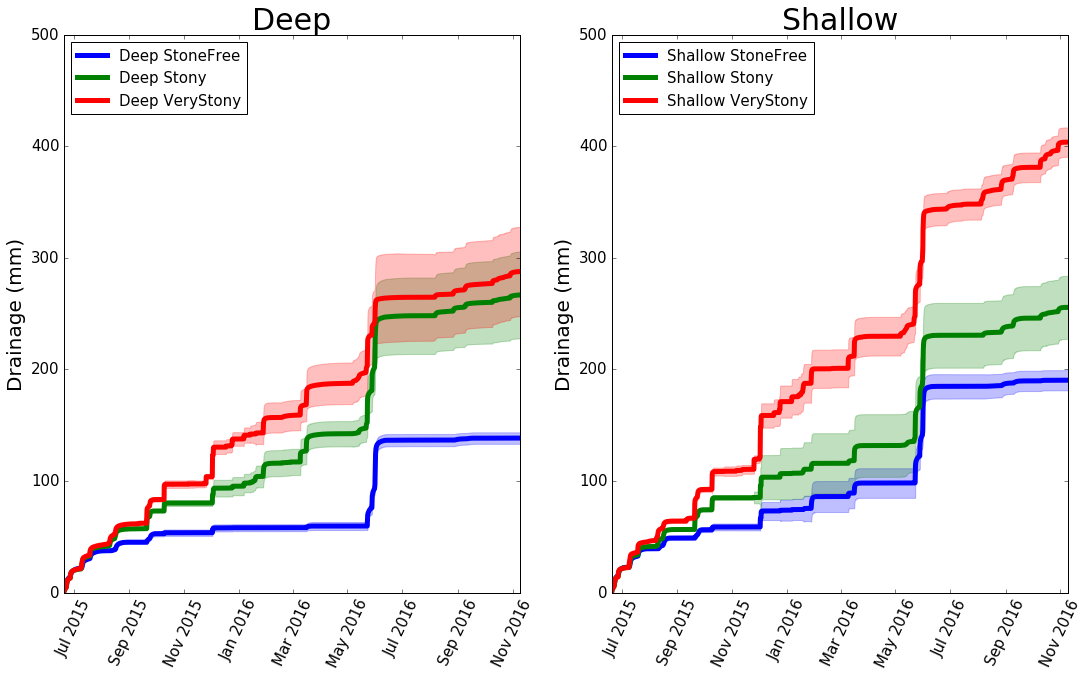

In [22]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,10))

GravPos = 0
for Grav in Gravels:
    fig = Graph.add_subplot(1,2,GravPos+1)
    StonPos = 0
    for Ston in Stones:
        median = Drainage.ix[:,('Drainage',Grav,Ston)].cumsum().median(axis=1)
        SEM = Drainage.ix[:,('Drainage',Grav,Ston)].cumsum().std(axis=1)/np.sqrt(4)
        Upper = median + SEM
        Lower = median - SEM
        plt.fill_between(Drainage.ix[:,('Drainage',Grav,Ston)].index,
                 Upper,
                 Lower,
                 color = colors[StonPos],alpha=0.25)
        plt.plot(Drainage.ix[:,('Drainage',Grav,Ston)].index,median,color=colors[StonPos],
                 linewidth = 5,
                 label = Grav+' ' +Ston)
        StonPos += 1
        plt.title(Grav, fontsize=30)
    GravPos +=1
    plt.ylim(0,500)
    plt.ylabel('Drainage (mm)', fontsize=20)
    plt.xticks(rotation=65)
    plt.tick_params(labelsize=15)    
    plt.legend(loc=2,numpoints=1,fontsize = 15)
plt.tight_layout

In [19]:
DailyDrainage = Drainage.resample('D',how='sum')

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


In [20]:
DrainageMask = DailyDrainage.where(DailyDrainage<1,1)
DrainageMask = DrainageMask.where(DrainageMask>=1,0)
DrainageMask = DrainageMask.where(DrainageMask!=1,np.nan)
DrainageMask = DrainageMask.where(DrainageMask!=0,1)

In [21]:
DrainageMask.to_pickle('.\Dataframes\DrainageMask')
DailyDrainage.to_pickle('.\Dataframes\Drainage')